In [1]:
from typing import Any
import os
import requests
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import wikipedia

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer
import tiktoken

from build_llm.gpt import GPTModel
from build_llm.util import generate_text_simple, create_dataloader_v1

## Verifica a presença da GPU:

In [2]:
print(torch.__version__)  # Versão do torch
print(torch.cuda.is_available())  # Verificação de GPU
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

2.5.1+cu121
True
NVIDIA GeForce RTX 4050 Laptop GPU
Usando: cuda


## Fixando o seed para reproducibilidade

In [3]:
def set_seed(seed: int = 42) -> None:
    """
    Fixa seeds para reprodutibilidade em Python, NumPy e PyTorch.
    """
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Garante determinismo (pode afetar performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(123)

## Configuração do modelo

As mesmas utilizadas no notebook [01 - LLM architecture](./01%20-%20LLM%20architecture.ipynb)
**exceto** pela janela de contexto (context_length) que foi reduziada para 256 (anteriormente era 1024)

In [4]:
GPT_CONFIG_124M: dict[str, Any] = {
    "vocab_size": 50257,     # Tamanho do vocabulário
    "context_length": 256,   # Comprimento do contexto
    "emb_dim": 768,          # Dimensão do embedding
    "n_heads": 12,           # Número de cabeças de atenção
    "n_layers": 12,          # Número de camadas
    "drop_rate": 0.1,        # Taxa de dropout
    "qkv_bias": False,       # Viés em Query-Key-Value (QKV)
}

In [5]:
# Define a semente para reprodutibilidade
torch.manual_seed(123)

# Instancia o modelo com a configuração desejada
model = GPTModel(GPT_CONFIG_124M)

# Coloca o modelo em modo de avaliação (desativa dropout, etc.)
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [6]:
def text_to_token_ids(text: str, tokenizer) -> torch.Tensor:
    """
    Converte um texto em IDs de tokens e retorna um tensor (com dimensão de batch).

    Parâmetros:
    ----------
    text : str
        Texto de entrada a ser tokenizado.
    tokenizer : Any
        Tokenizer compatível com a API do `tiktoken` (precisa ter `.encode`).

    Retorno:
    -------
    torch.Tensor
        Tensor com shape (1, seq_len), contendo os IDs de tokens.

    Exceções:
    --------
    Levanta TypeError se `text` não for string.
    Levanta RuntimeError se falhar ao codificar o texto.
    """
    if not isinstance(text, str):
        raise TypeError("O parâmetro `text` deve ser do tipo str.")

    try:
        encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        return torch.tensor(encoded, dtype=torch.long).unsqueeze(0)  # adiciona batch
    except Exception as e:
        raise RuntimeError("Falha ao converter texto em token IDs.") from e


def token_ids_to_text(token_ids: torch.Tensor, tokenizer) -> str:
    """
    Converte um tensor de IDs de tokens (com dimensão de batch) de volta para texto.

    Parâmetros:
    ----------
    token_ids : torch.Tensor
        Tensor com shape (1, seq_len) (ou compatível) contendo IDs de tokens.
    tokenizer : Any
        Tokenizer compatível com a API do `tiktoken` (precisa ter `.decode`).

    Retorno:
    -------
    str
        Texto decodificado.

    Exceções:
    --------
    Levanta TypeError se `token_ids` não for um torch.Tensor.
    Levanta ValueError se o tensor estiver vazio.
    """
    if not isinstance(token_ids, torch.Tensor):
        raise TypeError("O parâmetro `token_ids` deve ser um torch.Tensor.")
    if token_ids.numel() == 0:
        raise ValueError("`token_ids` não pode estar vazio.")

    flat = token_ids.squeeze(0)  # remove batch
    return tokenizer.decode(flat.tolist())


In [7]:
# Texto inicial (prompt) para geração
start_context = "Uma noite destas, vindo da cidade para o"

# Inicializa o tokenizer (encoding compatível com GPT-2)
tokenizer = tiktoken.get_encoding("gpt2")

# Converte o texto em IDs de tokens e gera novos tokens
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

# Texto será aleatório pois o modelo não foi treinado
output_text = token_ids_to_text(token_ids, tokenizer)
print(f"Output text:\n{output_text}")


Output text:
Uma noite destas, vindo da cidade para oralcycleardedEXPladoin grittyfracrenheit days


## Buscando o livro 'Dom Casmurro' de Machado de Assis (Projeto Gutenberg)

Url.: https://www.gutenberg.org/ebooks/55752

In [8]:
file_path = "../../data/dom_casmurro.txt"
url = "https://www.gutenberg.org/cache/epub/55752/pg55752.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

print("Salvo:", "dom_casmurro.txt")

Salvo: dom_casmurro.txt


In [9]:
# Calcula estatísticas do texto
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

# Exibe os resultados
print("Total de caracteres:", total_characters)
print("Total de tokens:", total_tokens)
print(f"Relação: {total_characters / total_tokens:.2f} caracteres por token")

Total de caracteres: 400907
Total de tokens: 160216
Relação: 2.50 caracteres por token


## Treinamento do modelo

In [10]:
# Divide o texto em treino e validação
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# Cria o DataLoader de treino
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

# Cria o DataLoader de validação
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [11]:
# Inspeciona os batches do DataLoader de treino
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

# Inspeciona os batches do DataLoader de validação
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

In [12]:
# Conta a quantidade de tokens (elementos) nos batches de treino
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

# Conta a quantidade de tokens (elementos) nos batches de validação
val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

# Exibe os totais
print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 145408
Validation tokens: 14592
All tokens: 160000


In [13]:
def calc_loss_batch(
    input_batch: torch.Tensor,
    target_batch: torch.Tensor,
    model: nn.Module,
    device: torch.device,
) -> torch.Tensor:
    """
    Calcula a loss (cross-entropy) para um único batch.

    Parâmetros:
    ----------
    input_batch : torch.Tensor
        Tensor de entradas (tokens) do batch.
    target_batch : torch.Tensor
        Tensor de targets do batch.
    model : nn.Module
        Modelo que retorna logits no forward.
    device : torch.device
        Dispositivo de execução (CPU/GPU).

    Retorno:
    -------
    torch.Tensor
        Loss do batch (tensor escalar).
    """
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)  # esperado: (B, T, V)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),          # (B*T, V)
        target_batch.flatten(),        # (B*T,)
    )
    return loss


def calc_loss_loader(
    data_loader: DataLoader,
    model: nn.Module,
    device: torch.device,
    num_batches: int | None = None,
) -> float:
    """
    Calcula a loss média ao longo de um DataLoader.

    Parâmetros:
    ----------
    data_loader : DataLoader
        DataLoader que retorna (input_batch, target_batch).
    model : nn.Module
        Modelo que retorna logits no forward.
    device : torch.device
        Dispositivo de execução (CPU/GPU).
    num_batches : int | None, default = None
        Se fornecido, limita o cálculo aos primeiros `num_batches` batches.

    Retorno:
    -------
    float
        Loss média no conjunto avaliado. Retorna NaN se o loader estiver vazio.
    """
    if len(data_loader) == 0:
        return float("nan")

    max_batches = len(data_loader) if num_batches is None else min(num_batches, len(data_loader))

    total_loss = 0.0
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= max_batches:
            break

        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += float(loss.item())

    return total_loss / max_batches

In [14]:
def get_device() -> torch.device:
    """
    Retorna o device apropriado (CUDA se disponível, caso contrário CPU).
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Seleciona o dispositivo (CPU/GPU) e move o modelo
device = get_device()
model.to(device)

# Calcula as losses sem rastrear gradientes
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)


Training loss: 10.985156301041725
Validation loss: 11.066163359017208


In [16]:
def train_model_simple(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: Optimizer,
    device: torch.device,
    num_epochs: int,
    eval_freq: int,
    eval_iter: int,
    start_context: str,
    tokenizer,
) -> tuple[list[float], list[float], list[int]]:
    """
    Treina o modelo e avalia periodicamente, registrando perdas e tokens vistos.

    Retorno:
    -------
    tuple[list[float], list[float], list[int]]
        (train_losses, val_losses, track_tokens_seen)
    """
    # Inicializa listas para acompanhar perdas e tokens vistos
    train_losses: list[float] = []
    val_losses: list[float] = []
    track_tokens_seen: list[int] = []

    tokens_seen = 0
    global_step = -1

    # Loop principal de treinamento
    for epoch in range(num_epochs):
        model.train()  # Coloca o modelo em modo de treino

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Zera os gradientes acumulados do batch anterior
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calcula os gradientes da loss
            optimizer.step()  # Atualiza os pesos do modelo usando os gradientes

            tokens_seen += input_batch.numel()
            global_step += 1

            # Etapa opcional de avaliação
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    device=device,
                    eval_iter=eval_iter,
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(
                    f"Ep {epoch + 1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Imprime um texto de exemplo ao final de cada época
        generate_and_print_sample(
            model=model,
            tokenizer=tokenizer,
            device=device,
            start_context=start_context,
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    eval_iter: int,
) -> tuple[float, float]:
    """
    Avalia o modelo em treino e validação usando um número limitado de batches.
    """
    model.eval()  # Coloca o modelo em modo de avaliação
    with torch.no_grad():
        train_loss = calc_loss_loader(
            data_loader=train_loader,
            model=model,
            device=device,
            num_batches=eval_iter,
        )
        val_loss = calc_loss_loader(
            data_loader=val_loader,
            model=model,
            device=device,
            num_batches=eval_iter,
        )
    model.train()  # Restaura o modo de treino
    return train_loss, val_loss


def generate_and_print_sample(
    model: nn.Module,
    tokenizer,
    device: torch.device,
    start_context: str,
) -> None:
    """
    Gera um pequeno texto a partir de `start_context` e imprime na tela.
    """
    model.eval()  # Coloca o modelo em modo de avaliação

    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size,
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Impressão compacta (sem quebras de linha)

    model.train()  # Restaura o modo de treino


## Início do treinamento

In [17]:
# Marca o tempo de início
start_time = time.time()

# Instancia o modelo e move para o dispositivo (CPU/GPU)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

# Configura o otimizador (AdamW)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=4e-4,
    weight_decay=0.1,
)

# Treina o modelo
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Uma noite destas, vindo da cidade para o",
    tokenizer=tokenizer,
)

# Calcula e exibe o tempo total de execução
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Treino completo em {execution_time_minutes:.2f} minutos.")

Ep 1 (Step 000000): Train loss 9.951, Val loss 9.965
Ep 1 (Step 000005): Train loss 8.290, Val loss 8.247
Ep 1 (Step 000010): Train loss 7.009, Val loss 6.999
Ep 1 (Step 000015): Train loss 6.460, Val loss 6.507
Ep 1 (Step 000020): Train loss 6.765, Val loss 6.390
Ep 1 (Step 000025): Train loss 6.421, Val loss 6.326
Ep 1 (Step 000030): Train loss 6.198, Val loss 6.206
Ep 1 (Step 000035): Train loss 6.208, Val loss 6.107
Ep 1 (Step 000040): Train loss 5.901, Val loss 6.001
Ep 1 (Step 000045): Train loss 5.817, Val loss 5.906
Ep 1 (Step 000050): Train loss 5.851, Val loss 5.753
Ep 1 (Step 000055): Train loss 5.654, Val loss 5.609
Ep 1 (Step 000060): Train loss 5.229, Val loss 5.515
Ep 1 (Step 000065): Train loss 5.447, Val loss 5.420
Ep 1 (Step 000070): Train loss 5.189, Val loss 5.350
Ep 1 (Step 000075): Train loss 5.279, Val loss 5.272
Ep 1 (Step 000080): Train loss 5.024, Val loss 5.188
Ep 1 (Step 000085): Train loss 5.132, Val loss 5.128
Ep 1 (Step 000090): Train loss 4.963, Val loss

## Plot do Loss de treinamento e validação

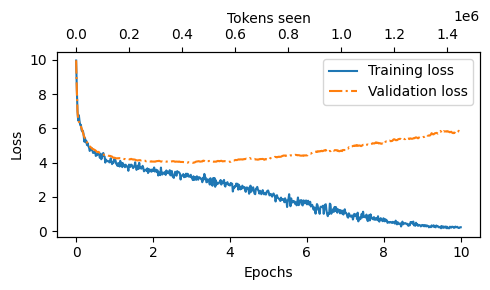

In [18]:
def plot_losses(
    epochs_seen: torch.Tensor,
    tokens_seen: list[int] | torch.Tensor,
    train_losses: list[float],
    val_losses: list[float],
    output_path: str = "loss-plot.pdf",
) -> None:
    """
    Plota as perdas (treino e validação) em função das épocas e adiciona um segundo eixo
    x para a quantidade de tokens vistos.

    Parâmetros:
    ----------
    epochs_seen : torch.Tensor
        Valores no eixo x representando as épocas correspondentes às medições.
    tokens_seen : list[int] | torch.Tensor
        Quantidade acumulada de tokens processados nas medições.
    train_losses : list[float]
        Lista de perdas de treino.
    val_losses : list[float]
        Lista de perdas de validação.
    output_path : str, default = "loss-plot.pdf"
        Caminho do arquivo de saída para salvar o gráfico.
    """
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plota as losses de treino e validação em função das épocas
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # Mostra apenas inteiros no eixo x

    # Cria um segundo eixo x para tokens vistos
    ax2 = ax1.twiny()  # Cria um segundo eixo x compartilhando o mesmo eixo y
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Plot invisível apenas para alinhar os ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Ajusta o layout para caber bem
    plt.savefig(output_path)
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Realiza a inferência

In [19]:
# Define o dispositivo para inferência (CPU)
inference_device = torch.device("cpu")

# Move o modelo para o dispositivo de inferência e coloca em modo de avaliação
model.to(inference_device)
model.eval()

# Inicializa o tokenizer (encoding compatível com GPT-2)
tokenizer = tiktoken.get_encoding("gpt2")

# Gera texto a partir de um prompt inicial
prompt = "Uma noite destas, vindo da cidade para o"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer).to(inference_device),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
)

# Decodifica e imprime o resultado
output_text = token_ids_to_text(token_ids, tokenizer)
print(f"Texto de saída:\n{output_text}")


Texto de saída:
Uma noite destas, vindo da cidade para ou do ancianidade viçosa, á escolha... Mas não

melancolias, á saidação.

--Tinha no gabinete do accender dizer a


In [21]:
# Gera texto a partir de um prompt inicial
prompt = "Quando voltámos, á noite, viemos por alli"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer).to(inference_device),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
)

# Decodifica e imprime o resultado
output_text = token_ids_to_text(token_ids, tokenizer)
print(f"Texto de saída:\n{output_text}")


Texto de saída:
Quando voltámos, á noite, viemos por alli que a gente vida eu ia e o que ficava
quaes na no claustro.

--Vocês muito, e a pae!

No dava já o que
